

# **Préparer les données**

### **Monter le dossier dans Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Projet_HMIN339M')

### **Importation de quelques librairies**

In [ ]:
import numpy as np
import tifffile
import glob
from pathlib import Path
import pandas as pd

### **Lecture de la série temporelle d'images et Normalisation par bande sur la série temporelle entre 0 et 1** 

#### **Lecture des images et création des séries temporelles de bandes**

In [ ]:
# Récupérer la liste des images
lst_img = glob.glob ('Images/*.tif')
lst_img.sort() # ordonner par date si ce n'est pas le cas
lst_img

['Images/20160322_S2A.tif',
 'Images/20160710_S2A.tif',
 'Images/20160730_S2A.tif',
 'Images/20160928_S2A.tif',
 'Images/20161018_S2A.tif',
 'Images/20161127_S2A.tif',
 'Images/20161217_S2A.tif',
 'Images/20161227_S2A.tif']

In [ ]:
# Lecture de la bande du rouge (B1) pour toute la série temporelle
red_ts = []
for img in lst_img:
  red_ts.append( tifffile.imread(img)[:,:,0]) # Rouge
red_ts = np.dstack(red_ts) #dstack a voir!
red_ts.shape
# red_ts : nombre de rouge dans chaque pixel
# largeur, longueur, nb d'image

(5412, 5592, 8)

In [ ]:
# Lecture de la bande du vert (B2) pour toute la série temporelle
green_ts = []
for img in lst_img:
  green_ts.append( tifffile.imread(img)[:,:,1]) # Vert
green_ts = np.dstack(green_ts)
green_ts.shape

(5412, 5592, 8)

In [ ]:
# Lecture de la bande du bleu (B3) pour toute la série temporelle
blue_ts = []
for img in lst_img:
  blue_ts.append( tifffile.imread(img)[:,:,2]) # Bleu
blue_ts = np.dstack(blue_ts)
blue_ts.shape

(5412, 5592, 8)

In [ ]:
# Lecture de la bande du proche infrarouge (B4) pour toute la série temporelle
nir_ts = []
for img in lst_img:
  nir_ts.append( tifffile.imread(img)[:,:,3]) # Proche infra rouge
nir_ts = np.dstack(nir_ts)
nir_ts.shape

(5412, 5592, 8)

In [ ]:
# Calculer des indices spectraux comme le NDVI

#### **Normalisation en utilisant le min et le max des bandes sur les séries temporelles**

normalisation pour avoir des valeurs entre 0 et 1

In [ ]:
red_ts.shape

(5412, 5592, 8)

In [ ]:
# Normalisation des séries temporelles par bande: Rouge
red_ts_norm = ( red_ts - red_ts.min() ) / ( red_ts.max() - red_ts.min() ).astype(np.float32)
red_ts_norm.min() , red_ts_norm.max(), red_ts_norm.shape, red_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normalisation des séries temporelles par bande: Vert
green_ts_norm = ( green_ts - green_ts.min() ) / ( green_ts.max() - green_ts.min() ).astype(np.float32)
green_ts = None
green_ts_norm.min() , green_ts_norm.max(), green_ts_norm.shape, green_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normalisation des séries temporelles par bande: Bleu
blue_ts_norm = ( blue_ts - blue_ts.min() ) / ( blue_ts.max() - blue_ts.min() ).astype(np.float32)
blue_ts = None
blue_ts_norm.min() , blue_ts_norm.max(), blue_ts_norm.shape, blue_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normalisation des séries temporelles par bande: Proche infrarouge
nir_ts_norm = ( nir_ts - nir_ts.min() ) / ( nir_ts.max() - nir_ts.min() ).astype(np.float32)
nir_ts_norm.min() , nir_ts_norm.max(), nir_ts_norm.shape, nir_ts_norm.dtype

(0.0, 1.0, (5412, 5592, 8), dtype('float32'))

In [ ]:
# Normaliser les indices spectraux que vous aurez calculé

### **Lecture de la vérité terrain et récupération des positions des pixels du jeu d'entraînement et de test**

#### **Lecture des fichiers de la vérité terrain**

In [ ]:
# Lire le fichier correspondant aux classes d'occupation du sol
gt_class = tifffile.imread ('Verite_terrain/DORDOGNE_VT_CLASS.tif')
gt_class.shape , gt_class.dtype

((5412, 5592), dtype('uint8'))

In [ ]:
# Lire le fichier correspondant aux identifiants
gt_id = tifffile.imread ('Verite_terrain/DORDOGNE_VT_ID.tif')
gt_id.shape, gt_id.dtype

((5412, 5592), dtype('int16'))

#### **Récupération des positions des pixels d'entraînement et de test**

In [ ]:
# Récupérer les positions des échantillons d'entraînement et test
idx_train_ = np.where ( (gt_id!=0) & (gt_class!=0) ) #les pixels that we care
idx_test = np.where ( (gt_id!=0) & (gt_class==0) ) #les pixels qui ont des id mais pas de classe, donc a deviner

In [ ]:
# Lecture des identifiants et labels des échantillons d'entraînement
train_id_ = gt_id[idx_train_] #identifiants de ces pixels
train_y_ = gt_class[idx_train_] #classes
f'échantillons d\'entrainement: {train_y_.shape[0]} pixels, {len(np.unique(train_id_))} objets' #identifiants non uniques

"échantillons d'entrainement: 605431 pixels, 1859 objets"

In [ ]:
# Lecture des identifiants et labels des échantillons de test
test_id = gt_id[idx_test]
f'échantillons test: {test_id.shape[0]} pixels, {len(np.unique(test_id))} objets'

'échantillons test: 207485 pixels, 800 objets'

### **Création d'un jeu de validation en prenant une partie du jeu d'entraînement**
Pour cela, on s'assure de faire la division en mettant les pixels ayant le même identifiant dans un seul et même lot

In [ ]:
# Dataframe pour créer un jeu de validation
samples = pd.DataFrame({'ID':train_id_,'Class':train_y_})
samples = samples.drop_duplicates(keep='first')
samples.head(5)

,ID,Class
0,422,2
4,2677,5
5,201,3
29,423,2
100,496,2


In [ ]:
# 30% des échantillons de chaque classe affecté au jeu de validation
train_id = []
valid_id = []
for c in np.unique(samples.Class.values) :
    samples_c = samples.loc[samples.Class==c]
    samples_frac = samples_c.sample(frac=0.7,random_state=1234) 
    train_id.extend( samples_frac.ID.values )
    valid_id.extend( samples_c.drop(samples_frac.index).ID.values )
len(train_id),len(valid_id)

(1301, 558)

### **Récupération des positions des nouveaux échantillons d'entraînement et de validation**

In [ ]:
# Récupérer les positions des nouveaux échantillons d'entraînement et validation
idx_train = np.where ( np.isin(gt_id,train_id) )
idx_valid = np.where ( np.isin(gt_id,valid_id) )

### **Lire finalement les labels correspondant aux nouveaux échantillons d'entraînement, de validation et test**

In [ ]:
train_y = gt_class[idx_train]
valid_y = gt_class[idx_valid]
test_y = gt_class[idx_test]
train_y.shape, valid_y.shape, test_y.shape

((451962,), (153469,), (207485,))

### **Lire finalement les identifiants correspondant aux nouveaux échantillons d'entraînement, de validation et test**

In [ ]:
# utile pour les aggrégations au niveau objet
# train_id_array = gt_id[idx_train] # Pas vraiment nécessaire pour les échantillons d'entraînements
valid_id_array = gt_id[idx_valid]
test_id_array = gt_id[idx_test]
#train_id_array.shape, 
valid_id_array.shape, test_id_array.shape

((153469,), (207485,))

### **Lire finalement les valeurs des séries temporelles correspondant aux nouveaux échantillons d'entraînement, de validation et test**

### **Pour un Perceptron multi-couche**

**Echantillons d'entraînement, de validation et test de MLP**

In [ ]:
# Un perceptron multi-couche ou un algo classique de machine learning requiert un tableau 2D du type 
# (nombre d'échantillons, nombre de features=(nombre de dates x nombre de bandes))
# Vous pouvez rajouter au stack les indices spectraux normalisés que vous aurez calculé

train_X = np.column_stack ( ( blue_ts_norm[idx_train], green_ts_norm[idx_train], red_ts_norm[idx_train], nir_ts_norm[idx_train] ) )

valid_X = np.column_stack ( ( blue_ts_norm[idx_valid], green_ts_norm[idx_valid], red_ts_norm[idx_valid], nir_ts_norm[idx_valid] ) )

test_X = np.column_stack ( ( blue_ts_norm[idx_test], green_ts_norm[idx_test], red_ts_norm[idx_test], nir_ts_norm[idx_test] ) )

train_X.shape, valid_X.shape, test_X.shape

((451962, 32), (153469, 32), (207485, 32))

**Sauvegarde des données d'entraînement, de validation et test de MLP en fichier numpy**

In [ ]:
# Ainsi de cette façon vous pourrez continuer directement avec la création des modèles et en libérant la mémoire de tout ce qui a été fait précédemment
Path('data').mkdir(exist_ok=True, parents=True)
Path('data/mlp').mkdir(exist_ok=True, parents=True)
np.save('data/mlp/train_X.npy',train_X)
np.save('data/mlp/train_y.npy',train_y)
# np.save('data/train_id.npy',train_id_array)

np.save('data/mlp/valid_X.npy',valid_X)
np.save('data/mlp/valid_y.npy',valid_y)
np.save('data/mlp/valid_id.npy',valid_id_array)

np.save('data/mlp/test_X.npy',test_X)
np.save('data/mlp/test_id.npy',test_id_array)

### **Pour un CNN 1D ou temporel**

Echantillons d'entraînement, de validation et test de CNN1D

In [ ]:
# Un CNN 1D ou temporel requiert un tableau 3D du type (nombre d'échantillons, nombre de dates, nombre de bandes)
# Vous pouvez rajouter à la liste des bandes les indices spectraux normalisés que vous aurez calculé
train_X = []
for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    train_X.append( band[idx_train] ) 
train_X = np.stack(train_X,axis=-1)

valid_X = []
for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    valid_X.append( band[idx_valid] ) 
valid_X = np.stack(valid_X,axis=-1)

test_X = []
for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    test_X.append( band[idx_test] ) 
test_X = np.stack(test_X,axis=-1)

train_X.shape, valid_X.shape, test_X.shape

((451962, 8, 4), (153469, 8, 4), (207485, 8, 4))

Sauvegarde des données d'entraînement, de validation et test de CNN1D en fichier numpy

In [ ]:
# Ainsi de cette façon vous pourrez continuer directement avec la création des modèles et en libérant la mémoire de tout ce qui a été fait précédemment
Path('data').mkdir(exist_ok=True, parents=True)
Path('data/cnn1d').mkdir(exist_ok=True, parents=True)
np.save('data/cnn1d/train_X.npy',train_X)
np.save('data/cnn1d/train_y.npy',train_y)
# np.save('data/train_id.npy',train_id_array)

np.save('data/cnn1d/valid_X.npy',valid_X)
np.save('data/cnn1d/valid_y.npy',valid_y)
np.save('data/cnn1d/valid_id.npy',valid_id_array)

np.save('data/cnn1d/test_X.npy',test_X)
np.save('data/cnn1d/test_id.npy',test_id_array)

### **Pour un CNN2D ou spatial avec exemple d'imagettes ou patchs de 5 sur 5 en largeur et hauteur** 

Des patchs de 9 sur 9 sur l'ensemble des échantillons sont un peu trop gourmands en RAM pour Google Colab

Echantillons d'entraînement, de validation et test de CNN2D

In [ ]:
# Un CNN 2D ou spatial requiert un tableau 3D du type (nombre d'échantillons, largeur, hauteur, nombre de features= (nombre de dates x nombre de bandes) )
# Vous pouvez rajouter à la liste des bandes les indices spectraux normalisés que vous aurez calculé

# Training
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_train[0]
idx_row = idx_train[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
train_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  train_X.append(np.stack(lst,axis=-1).reshape(5,5,-1))
train_X = np.stack(train_X,axis=0)
train_X.shape

(451962, 5, 5, 32)

In [ ]:
# Validation
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_valid[0]
idx_row = idx_valid[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
valid_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  valid_X.append(np.stack(lst,axis=-1).reshape(5,5,-1))
valid_X = np.stack(valid_X,axis=0)
valid_X.shape

(153469, 5, 5, 32)

In [ ]:
# Test
# 1- précaution pour ne pas considérer les pixels dont on ne peut extraire des patchs car trop près du bord
idx_col = idx_test[0]
idx_row = idx_test[1]
coords = np.column_stack((idx_col,idx_row))
coords = coords[np.where( ( np.isin(coords[:,0],np.arange(2,blue_ts_norm.shape[0]-2,1)) ) & ( np.isin(coords[:,1],np.arange(2,blue_ts_norm.shape[1]-2,1)) ) ) ]
# len(coords)
# 2- créer un tableau avec les patchs
test_X = []
for coord in coords :
  lst = []
  for band in [blue_ts_norm,green_ts_norm,red_ts_norm,nir_ts_norm]:
    lst.append( band[coord[0]-2:coord[0]+3,coord[1]-2:coord[1]+3] )
  test_X.append(np.stack(lst,axis=-1).reshape(5,5,-1))
test_X = np.stack(test_X,axis=0)
test_X.shape

(207485, 5, 5, 32)

Sauvegarde des données d'entraînement, de validation et test de CNN2D en fichier numpy

In [ ]:
# Ainsi de cette façon vous pourrez continuer directement avec la création des modèles et en libérant la mémoire de tout ce qui a été fait précédemment
Path('data').mkdir(exist_ok=True, parents=True)
Path('data/cnn2d').mkdir(exist_ok=True, parents=True)

np.save('data/cnn2d/train_X.npy',train_X)
np.save('data/cnn2d/train_y.npy',train_y)
# np.save('data/train_id.npy',train_id_array)

np.save('data/cnn2d/valid_X.npy',valid_X)
np.save('data/cnn2d/valid_y.npy',valid_y)
np.save('data/cnn2d/valid_id.npy',valid_id_array)

np.save('data/cnn2d/test_X.npy',test_X)
np.save('data/cnn2d/test_id.npy',test_id_array)

Videz la mémoire en redémarrant l'environnement d'exécution

# **Votre modèle de deep learning**

### **Remontage de Drive et Importation de quelques librairies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Projet_HMIN339M')
import numpy as np
import pandas as pd
import tifffile
from pathlib import Path
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, GlobalAveragePooling1D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

### **Recharger les données d'entraînement, de validation et test en fichier numpy**


#### **Pour un Perceptron multi-couche**

In [ ]:
# Recharger les données après avoir vidé la mémoire
train_X = np.load('data/mlp/train_X.npy')
train_y = np.load('data/mlp/train_y.npy')

valid_X = np.load('data/mlp/valid_X.npy')
valid_y = np.load('data/mlp/valid_y.npy')
valid_id = np.load('data/mlp/valid_id.npy')

test_X = np.load('data/mlp/test_X.npy')
test_id = np.load('data/mlp/test_id.npy')
train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, valid_id.shape, test_X.shape, test_id.shape

((451962, 32),
 (451962,),
 (153469, 32),
 (153469,),
 (153469,),
 (207485, 32),
 (207485,))

#### **Pour un CNN 1D ou temporel**


In [ ]:
# Recharger les données après avoir vidé la mémoire
train_X = np.load('data/cnn1d/train_X.npy')
train_y = np.load('data/cnn1d/train_y.npy')

valid_X = np.load('data/cnn1d/valid_X.npy')
valid_y = np.load('data/cnn1d/valid_y.npy')
valid_id = np.load('data/cnn1d/valid_id.npy')

test_X = np.load('data/cnn1d/test_X.npy')
test_id = np.load('data/cnn1d/test_id.npy')
train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, valid_id.shape, test_X.shape, test_id.shape

((451962, 8, 4),
 (451962,),
 (153469, 8, 4),
 (153469,),
 (153469,),
 (207485, 8, 4),
 (207485,))

#### **Pour un CNN 2D ou temporel**

In [ ]:
# Recharger les données après avoir vidé la mémoire
train_X = np.load('data/cnn2d/train_X.npy')
train_y = np.load('data/cnn2d/train_y.npy')

valid_X = np.load('data/cnn2d/valid_X.npy')
valid_y = np.load('data/cnn2d/valid_y.npy')
valid_id = np.load('data/cnn2d/valid_id.npy')

test_X = np.load('data/cnn2d/test_X.npy')
test_id = np.load('data/cnn2d/test_id.npy')
train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, valid_id.shape, test_X.shape, test_id.shape

((451962, 5, 5, 32),
 (451962,),
 (153469, 5, 5, 32),
 (153469,),
 (153469,),
 (207485, 5, 5, 32),
 (207485,))

### **Encoder les labels entre 0 et 4 de sorte à matcher les prédictions des réseaux de neurones**

In [ ]:
#encoder car l'algo aime bien commencer par 0
encoder = LabelEncoder()
encoder.fit(train_y)
train_y_enc = encoder.transform(train_y)
valid_y_enc = encoder.transform(valid_y)
np.unique(train_y), np.unique(train_y_enc), np.unique(valid_y), np.unique(valid_y_enc)

(array([1, 2, 3, 4, 5], dtype=uint8),
 array([0, 1, 2, 3, 4]),
 array([1, 2, 3, 4, 5], dtype=uint8),
 array([0, 1, 2, 3, 4]))

### **Définition séquentielle de votre modèle avec Keras**

N'oubliez pas de spécifier l'input shape qui varie en fonction des types d'architectures, le nombre de neurones de la couche de sortie qui équivaut au nombre de classes que vous avez et de l'activer avec une fonction Softmax

### Modèle CNN1D

In [ ]:
model = Sequential() #model cnn1d
model.add(Conv1D(32, 3, activation='relu', input_shape=(8,4)))
model.add(Dropout(0.3))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalAveragePooling1D())
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 6, 32)             416       
_________________________________________________________________
dropout_12 (Dropout)         (None, 6, 32)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4, 64)             6208      
_________________________________________________________________
dropout_13 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 2, 128)            24704     
_________________________________________________________________
dropout_14 (Dropout)         (None, 2, 128)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 128)           

### Modèle CNN2D

In [ ]:
model = Sequential() # Modele CNN2D
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(5,5,32)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (1,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 3, 3, 32)          9248      
_________________________________________________________________
dropout_34 (Dropout)         (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)          2112      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 1, 1, 64)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)                

### Modèle MLP

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.Input(shape=(32)),
                             tf.keras.layers.Dense(64, activation='relu'),  
                             tf.keras.layers.Dropout(0.3), 
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.3)
                             ])

# .... à compléter ....4/1AY0e-g7ust680Kg4-eB33LbFtUsqxPhYKsUJg2KtuChzseU6ggxTDPtLusw
model.add(tf.keras.layers.Dense(5, activation='softmax'))
# Afficher votre modèle
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1

### **Compiler votre modèle en définissant une fonction de côut, un optmiseur et une métrique**

Dans le cas d'une classification multi-classe, votre fonction de coût est la cross entropy catégorique. $Adam$ est un bon optimiseur de départ pour vos projets. Ici vous pouvez surveiller la métrique $Accuracy$. Pour la fonction de coût (loss), je n'utilse pas l'argument $from\_logits=True$ car j'ai déjà activé la couche de sortie avec une fonction Softmax

In [ ]:
#optimizer = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer='sgd',loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['acc'])

### **Définir un callback pour sauver les poids de votre modèle sur les meilleures époque c'est à dire les moments où il s'améliorera sur le jeu de validation**

In [ ]:
#pour garder the best epoques -> saved in my_model
Path('my_model').mkdir(exist_ok=True, parents=True)
checkpointpath = os.path.join('my_model','model') # chemin où sauver le modèle
callbacks = [tf.keras.callbacks.ModelCheckpoint(
              checkpointpath,
              verbose=1, # niveau de log
              monitor='val_acc', # nom de la métrique à surveiller
              save_best_only=True, # sauver uniquement le meilleur modèle
              save_weights_only=True)] # sauver uniquement les poids

### **Entraîner votre modèle pour un certain nombre d'époques**

Le paramètre $validation\_data$ vous permet de spécifier des données de validation et de votre le comportement de votre modèle sur un jeu indépendant dont il n'a pas la connaissance. 

La taille de batch ($batch\_size$) correspond au nombre d'échantillons sur lesquels le modèle est entraîné à la fois sur une époque. Vous pouvez le mettre à (ex. 32, 64, 128, 256) et plus il est grand ce qui requiert d'avoir de la mémoire plus le temps d'exécution d'une époque sera court

J'utilise les labels encodés entre 0 et 4 car la prédiction sur les distributions de probabilités du modèle est retournée avec un argmax

In [ ]:
BATCH_SIZE = 128
EPOCHS = 50
history = model.fit (train_X, train_y_enc, validation_data=(valid_X,valid_y_enc), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/50
3523/3531 [============================>.] - ETA: 0s - loss: 0.7366 - acc: 0.7481
Epoch 00001: val_acc improved from -inf to 0.69283, saving model to my_model/model
3531/3531 [==============================] - 12s 3ms/step - loss: 0.7362 - acc: 0.7483 - val_loss: 0.7131 - val_acc: 0.6928
Epoch 2/50
3519/3531 [============================>.] - ETA: 0s - loss: 0.5158 - acc: 0.8302
Epoch 00002: val_acc improved from 0.69283 to 0.82241, saving model to my_model/model
3531/3531 [==============================] - 12s 3ms/step - loss: 0.5157 - acc: 0.8303 - val_loss: 0.5380 - val_acc: 0.8224
Epoch 3/50
3517/3531 [============================>.] - ETA: 0s - loss: 0.4686 - acc: 0.8507
Epoch 00003: val_acc improved from 0.82241 to 0.83351, saving model to my_model/model
3531/3531 [==============================] - 12s 3ms/step - loss: 0.4686 - acc: 0.8507 - val_loss: 0.4705 - val_acc: 0.8335
Epoch 4/50
3530/3531 [============================>.] - ETA: 0s - loss: 0.4471 - acc: 0.8558
E

### **Restaurer les poids du modèle sur la meilleure époque d'entraînement**

In [ ]:
model.load_weights(checkpointpath)
# S'assurer que c'est bien le meilleur modèle sur les époques d'entraînement
model.evaluate(valid_X,valid_y_enc,batch_size=256)
#test_y_enc = encoder.transform(test_y)
#test_loss, test_acc = model.evaluate(valid_X,  valid_y_enc, verbose=2)

600/600 [==============================] - 1s 2ms/step - loss: 0.2574 - acc: 0.9146


[0.25735926628112793, 0.9146211743354797]

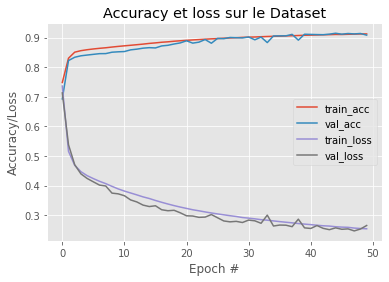

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, EPOCHS), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_acc"], label="val_acc")
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Accuracy et loss sur le Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="center right")

### **Prédiction des classes sur le jeu de validation et évaluation en aggrégeant au niveau objet**

In [ ]:
# Récupérer les probabilités prédites sur le jeu de validation
valid_prob = model.predict(valid_X,batch_size=256) # anciene modele
valid_prob.shape

(153469, 5)

In [ ]:
# Retourner la classe correspondant à la probabilité la plus haute
valid_pred = np.argmax(valid_prob,axis=1) # axe 1 car ceci concerne chaque ligne
valid_pred.shape
valid_pred.view()

array([2, 2, 2, ..., 4, 4, 4])

In [ ]:
# Je réencode les prédictions entre 1 et 5
valid_pred_enc = encoder.inverse_transform(valid_pred)
np.unique(valid_pred_enc)

array([2, 3, 4, 5], dtype=uint8)

In [ ]:
# Aggrégation au niveau objet
out_pred = []
unique_id = np.unique(valid_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = valid_pred_enc[np.where(valid_id==ID)]
    y_true = valid_y[np.where(valid_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    out_pred.append([ np.bincount(y_true).argmax(), np.bincount(pred).argmax()]) #(Vérité terrain,Prédiction majoritaire)
out_pred = np.vstack(out_pred)
out_pred.shape

(558, 2)

In [ ]:
# F1 score au niveau objet
f1_score(out_pred[:,0],out_pred[:,1],average='weighted')

0.8346598911375295

### **Prédire sur le jeu test et Préparer une soumission**

In [ ]:
# Récupérer les probabilités prédites sur le jeu test
test_prob = model.predict(test_X, batch_size=256)  
test_prob.shape

(207485, 5)

In [ ]:
# Retourner la classe correspondant à la probabilité la plus haute
test_pred = np.argmax(test_prob,axis=1) # axe 1 car ceci concerne chaque ligne
test_pred.shape

(207485,)

In [ ]:
# Je réencode les prédictions entre 1 et 5
test_pred_enc = encoder.inverse_transform(test_pred)
np.unique(test_pred_enc)

array([2, 3, 4, 5], dtype=uint8)

In [ ]:
# Aggrégation au niveau objet
agg_pred = []
unique_id = np.unique(test_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = test_pred_enc[np.where(test_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    agg_pred.append([ ID, np.bincount(pred).argmax()]) #(ID,Prédiction majoritaire)
agg_pred = np.vstack(agg_pred)
agg_pred.shape

(800, 2)

In [ ]:
df = pd.DataFrame({'ID':agg_pred[:,0],'Class':agg_pred[:,1]})
df.to_csv('Soumission_StefanMinyoungRaidh(1).csv',index=False)
df.head(5)

,ID,Class
0,4,5
1,7,3
2,8,5
3,9,3
4,10,3


In [ ]:
# F1 Score au niveau objet
!ls
df_test = pd.read_csv('Test_ID_Label.csv') # Ce fichier vous sera fourni le 12 Novembre
f1_score(df_test.Class,df.Class,average='weighted')

 data	     my_model				      Test_ID_Label.csv
 Images      Soumission_NomDuGroupe.csv		      Verite_terrain
 model.png  'Soumission_StefanMinyoungRaidh(1).csv'


0.8201881447069127

## **Modele CNN2D avec MLP**

### Modele MLP

In [ ]:
def mlpModel():
  input = tf.keras.Input(shape=(32))

  layer1 = Dense(64, activation='relu')(input)
  layer2 = Dropout(0.5)(layer1)
  layer3 = Dense(128, activation='relu')(layer2)
  layer4 = Dropout(0.5)(layer3)
  layer5 = Dense(256, activation='relu')(layer4)
  layer6 = Dropout(0.5)(layer5)
 # layer7 = Dense(32, activation='relu')(layer6)
 # layer8 = Dropout(0.3)(layer7)

  return tf.keras.Model(inputs=input, outputs=layer6)

mlp_model = mlpModel()
mlp_model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)             

### Model CNN2D

In [ ]:
def cnn2dModel():
  input = tf.keras.Input(shape=(5,5,32))

  layer1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input)
  layer2 = Dropout(0.5)(layer1)
  layer3 = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(layer2)
  layer4 = MaxPooling2D(2,2)(layer3)
  layer5 = Dropout(0.5)(layer4)
  layer6 = GlobalAveragePooling2D()(layer5)

  return tf.keras.Model(inputs=input, outputs=layer6)

cnn2d_model = cnn2dModel()
cnn2d_model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5, 5, 32)]        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 32)          9248      
_________________________________________________________________
dropout_22 (Dropout)         (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 64)          2112      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 1, 64)          0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)              

### Concatenation de deux modèles

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 5, 5, 32)]   0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 64)           2112        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 3, 3, 32)     9248        input_8[0][0]                    
______________________________________________________________________________________

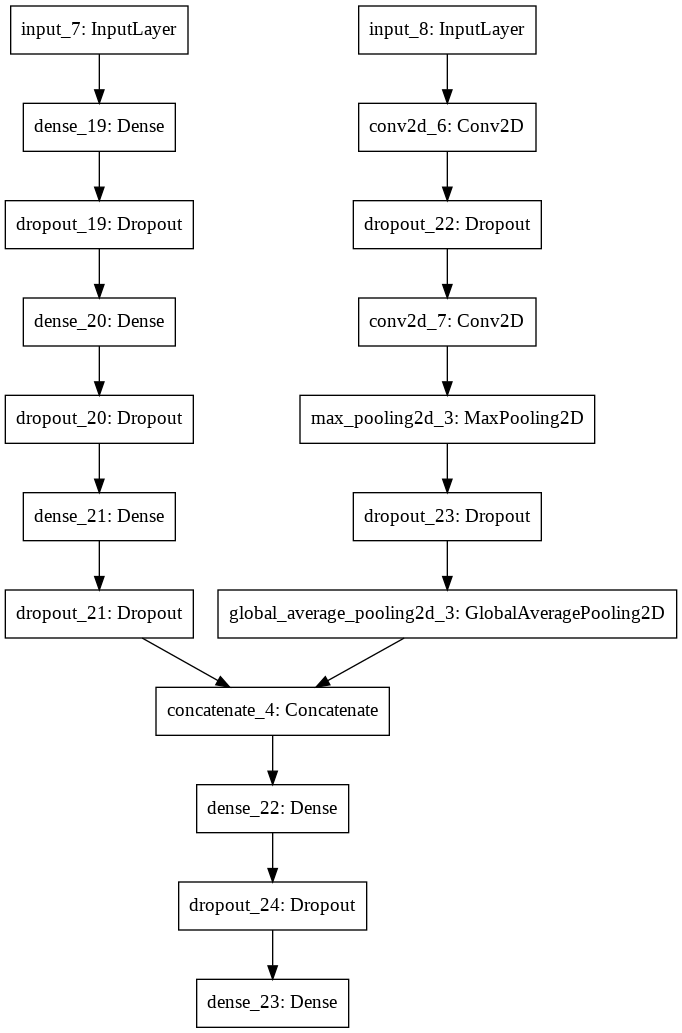

In [ ]:
concat = tf.keras.layers.Concatenate()([mlp_model.output, cnn2d_model.output])

layer_c = Dense(256, activation='relu')(concat)
layer_cc = Dropout(0.5)(layer_c)
out_layer = Dense(5, activation='softmax')(layer_cc)

new_model = tf.keras.Model(inputs=[mlp_model.input, cnn2d_model.input], outputs=out_layer)

new_model.summary()
tf.keras.utils.plot_model(new_model)

### Compilation et entrainement

In [ ]:
new_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['acc'])

In [ ]:
Path('my_model').mkdir(exist_ok=True, parents=True)
checkpointpath = os.path.join('my_model','new_model') # chemin où sauver le modèle
callbacks = [tf.keras.callbacks.ModelCheckpoint(
              checkpointpath,
              verbose=1, # niveau de log
              monitor='val_acc', # nom de la métrique à surveiller
              save_best_only=True, # sauver uniquement le meilleur modèle
              save_weights_only=True)] # sauver uniquement les poids

In [ ]:
train_X.shape

(451962, 5, 5, 32)

In [ ]:
train_X[:,2,2,:].shape

(451962, 32)

In [ ]:
train_X[:,2,2,:].reshape(train_X.shape[0], -1).shape

(451962, 32)

In [ ]:
BATCH_SIZE = 256
EPOCHS = 50
history = new_model.fit ([train_X[:,2,2,:].reshape(train_X.shape[0], -1), train_X], train_y_enc, validation_data=([valid_X[:,2,2,:].reshape(valid_X.shape[0], -1), valid_X],valid_y_enc), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/50
1765/1766 [============================>.] - ETA: 0s - loss: 0.4127 - acc: 0.8625
Epoch 00001: val_acc improved from -inf to 0.89735, saving model to my_model/new_model
1766/1766 [==============================] - 9s 5ms/step - loss: 0.4126 - acc: 0.8625 - val_loss: 0.3076 - val_acc: 0.8973
Epoch 2/50
1765/1766 [============================>.] - ETA: 0s - loss: 0.2992 - acc: 0.9015
Epoch 00002: val_acc improved from 0.89735 to 0.90401, saving model to my_model/new_model
1766/1766 [==============================] - 9s 5ms/step - loss: 0.2992 - acc: 0.9015 - val_loss: 0.2687 - val_acc: 0.9040
Epoch 3/50
1760/1766 [============================>.] - ETA: 0s - loss: 0.2754 - acc: 0.9082
Epoch 00003: val_acc did not improve from 0.90401
1766/1766 [==============================] - 9s 5ms/step - loss: 0.2753 - acc: 0.9082 - val_loss: 0.2873 - val_acc: 0.8980
Epoch 4/50
1766/1766 [==============================] - ETA: 0s - loss: 0.2606 - acc: 0.9118
Epoch 00004: val_acc improved fr

### **Restaurer les poids du modèle sur la meilleure époque d'entraînement**

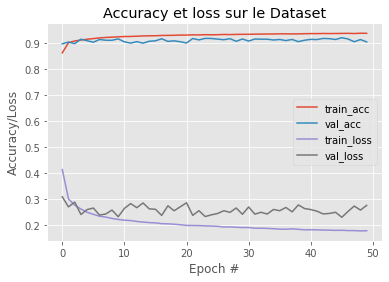

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, EPOCHS), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_acc"], label="val_acc")
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Accuracy et loss sur le Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="center right")

### **Prédiction des classes sur le jeu de validation et évaluation en aggrégeant au niveau objet**

In [ ]:
# Récupérer les probabilités prédites sur le jeu de validation
#valid_prob = model.predict(valid_X,batch_size=256) # anciene modele
valid_prob = new_model.predict([valid_X[:,2,2,:].reshape(valid_X.shape[0], -1), valid_X],batch_size=256) # pour le modele de avec cnn2d et mlp ensemble
valid_prob.shape

(153469, 5)

In [ ]:
# Retourner la classe correspondant à la probabilité la plus haute
valid_pred = np.argmax(valid_prob,axis=1) # axe 1 car ceci concerne chaque ligne
valid_pred.shape
valid_pred.view()

array([2, 1, 1, ..., 4, 4, 4])

In [ ]:
# Je réencode les prédictions entre 1 et 5
valid_pred_enc = encoder.inverse_transform(valid_pred)
np.unique(valid_pred_enc)

array([1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
# Aggrégation au niveau objet
out_pred = []
unique_id = np.unique(valid_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = valid_pred_enc[np.where(valid_id==ID)]
    y_true = valid_y[np.where(valid_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    out_pred.append([ np.bincount(y_true).argmax(), np.bincount(pred).argmax()]) #(Vérité terrain,Prédiction majoritaire)
out_pred = np.vstack(out_pred)
out_pred.shape

(558, 2)

In [ ]:
# F1 score au niveau objet
f1_score(out_pred[:,0],out_pred[:,1],average='weighted')

0.8533575784178195

### **Prédire sur le jeu test et Préparer une soumission**

In [ ]:
# Récupérer les probabilités prédites sur le jeu test
# test_prob = new_model.predict(test_X, batch_size=256) ancien pour predir d'un seul modele 
test_prob = new_model.predict([test_X[:,2,2,:].reshape(test_X.shape[0], -1), test_X],batch_size=256) # prédiction de deux modeles combiné
test_prob.shape

(207485, 5)

In [ ]:
# Retourner la classe correspondant à la probabilité la plus haute
test_pred = np.argmax(test_prob,axis=1) # axe 1 car ceci concerne chaque ligne
test_pred.shape

(207485,)

In [ ]:
# Je réencode les prédictions entre 1 et 5
test_pred_enc = encoder.inverse_transform(test_pred)
np.unique(test_pred_enc)

array([1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
# Aggrégation au niveau objet
agg_pred = []
unique_id = np.unique(test_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = test_pred_enc[np.where(test_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    agg_pred.append([ ID, np.bincount(pred).argmax()]) #(ID,Prédiction majoritaire)
agg_pred = np.vstack(agg_pred)
agg_pred.shape

(800, 2)

In [ ]:
df = pd.DataFrame({'ID':agg_pred[:,0],'Class':agg_pred[:,1]})
df.to_csv('Soumission_StefanMinyoungRaidh(1).csv',index=False)
df.head(5)

,ID,Class
0,4,5
1,7,3
2,8,5
3,9,3
4,10,3


In [ ]:
# F1 Score au niveau objet
!ls
df_test = pd.read_csv('Test_ID_Label.csv') # Ce fichier vous sera fourni le 12 Novembre
f1_score(df_test.Class,df.Class,average='weighted')

 data	     my_model				      Test_ID_Label.csv
 Images      Soumission_NomDuGroupe.csv		      Verite_terrain
 model.png  'Soumission_StefanMinyoungRaidh(1).csv'


0.8255986832267115

## **Modele CNN1D avec MLP**

### Modele MLP

In [ ]:
def mlpModel():
  input = tf.keras.Input(shape=(32))

  layer1 = Dense(64, activation='relu')(input)
  layer2 = Dropout(0.3)(layer1)
  layer3 = Dense(128, activation='relu')(layer2)
  layer4 = Dropout(0.3)(layer3)
  layer5 = Dense(256, activation='relu')(layer4)
  layer6 = Dropout(0.3)(layer5)
 # layer7 = Dense(32, activation='relu')(layer6)
 # layer8 = Dropout(0.3)(layer7)

  return tf.keras.Model(inputs=input, outputs=layer6)

mlp_model = mlpModel()
mlp_model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)             

### Modele CNN1D

In [ ]:
def cnn1dModel():
  input = tf.keras.Input(shape=(8,4))

  layer1 = Conv1D(filters=32, kernel_size=3, activation='relu')(input)
  layer2 = Dropout(0.1)(layer1)
  layer3 = Conv1D(filters=64, kernel_size=3, activation='relu')(layer2)
  layer4 = Dropout(0.2)(layer3)
  layer5 = Conv1D(filters=128, kernel_size=3, activation='relu')(layer4)
  layer6 = Dropout(0.3)(layer5)
  layer7 = MaxPooling1D(2)(layer6)
  layer8 = GlobalAveragePooling1D()(layer7)

  return tf.keras.Model(inputs=input, outputs=layer8)

cnn1d_model = cnn1dModel()
cnn1d_model.summary() 


Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 8, 4)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 32)             416       
_________________________________________________________________
dropout_28 (Dropout)         (None, 6, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 64)             6208      
_________________________________________________________________
dropout_29 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            24704     
_________________________________________________________________
dropout_30 (Dropout)         (None, 2, 128)          

### Concaténation

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 8, 4)]       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 6, 32)        416         input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 6, 32)        0           conv1d[0][0]                     
______________________________________________________________________________________

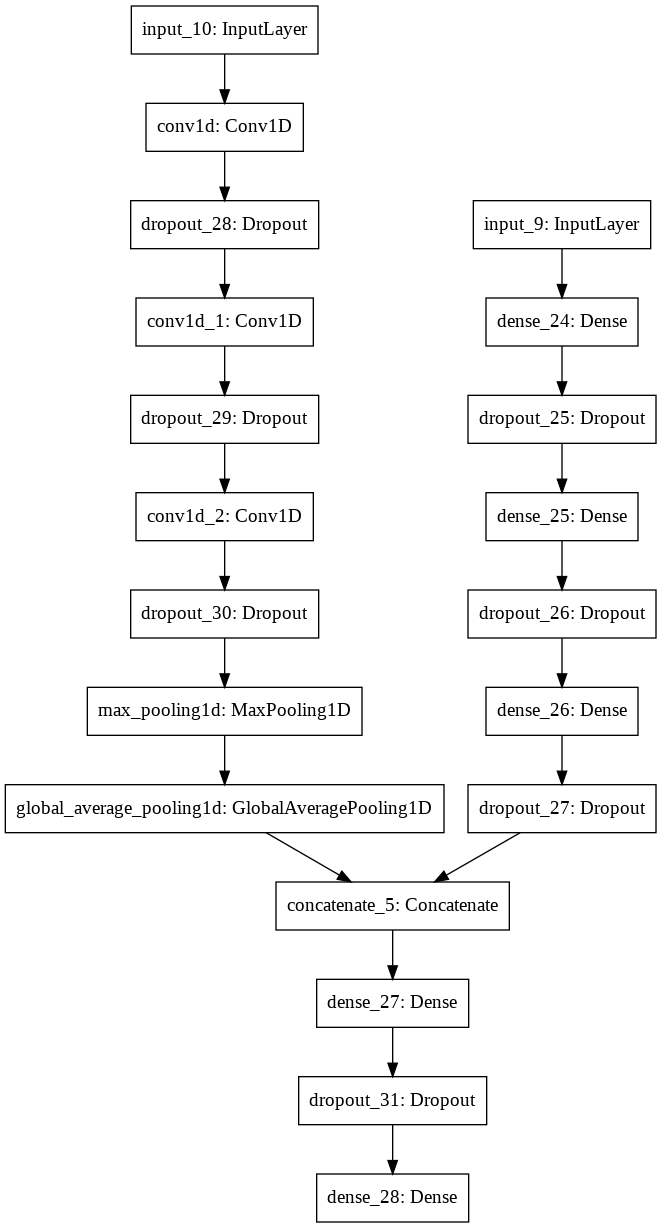

In [ ]:
concat = tf.keras.layers.Concatenate()([mlp_model.output, cnn1d_model.output])

layer_c = Dense(256, activation='relu')(concat)
layer_cc = Dropout(0.5)(layer_c)
out_layer = Dense(5, activation='softmax')(layer_cc)

new_model = tf.keras.Model(inputs=[mlp_model.input, cnn1d_model.input], outputs=out_layer)

new_model.summary()
tf.keras.utils.plot_model(new_model)

### Compilation et Entrainement

In [ ]:
new_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['acc'])

In [ ]:
Path('my_model').mkdir(exist_ok=True, parents=True)
checkpointpath = os.path.join('my_model','new_model') # chemin où sauver le modèle
callbacks = [tf.keras.callbacks.ModelCheckpoint(
              checkpointpath,
              verbose=1, # niveau de log
              monitor='val_acc', # nom de la métrique à surveiller
              save_best_only=True, # sauver uniquement le meilleur modèle
              save_weights_only=True)] # sauver uniquement les poids

In [ ]:
BATCH_SIZE = 256
EPOCHS = 50
history = new_model.fit ([train_X[:,:,:].reshape(train_X.shape[0], -1), train_X], train_y_enc, validation_data=([valid_X[:,:,:].reshape(valid_X.shape[0], -1), valid_X],valid_y_enc), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/50
1766/1766 [==============================] - ETA: 0s - loss: 0.4273 - acc: 0.8571
Epoch 00001: val_acc improved from -inf to 0.87245, saving model to my_model/new_model
1766/1766 [==============================] - 8s 5ms/step - loss: 0.4273 - acc: 0.8571 - val_loss: 0.3319 - val_acc: 0.8724
Epoch 2/50
1755/1766 [============================>.] - ETA: 0s - loss: 0.3270 - acc: 0.8893
Epoch 00002: val_acc did not improve from 0.87245
1766/1766 [==============================] - 8s 4ms/step - loss: 0.3272 - acc: 0.8892 - val_loss: 0.3394 - val_acc: 0.8669
Epoch 3/50
1756/1766 [============================>.] - ETA: 0s - loss: 0.2992 - acc: 0.8977
Epoch 00003: val_acc improved from 0.87245 to 0.89368, saving model to my_model/new_model
1766/1766 [==============================] - 8s 5ms/step - loss: 0.2993 - acc: 0.8977 - val_loss: 0.2878 - val_acc: 0.8937
Epoch 4/50
1762/1766 [============================>.] - ETA: 0s - loss: 0.2835 - acc: 0.9026
Epoch 00004: val_acc improved fr

In [ ]:
new_model.load_weights(checkpointpath)
# S'assurer que c'est bien le meilleur modèle sur les époques d'entraînement
new_model.evaluate([valid_X[:,:,:].reshape(valid_X.shape[0], -1), valid_X],valid_y_enc,batch_size=256)

600/600 [==============================] - 1s 2ms/step - loss: 0.2675 - acc: 0.9050


[0.2674950659275055, 0.905049204826355]

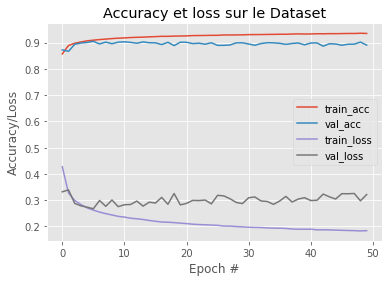

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, EPOCHS), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_acc"], label="val_acc")
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Accuracy et loss sur le Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="center right")

### Prédiction des classes sur le jeu de validation et évaluation en aggrégeant au niveau objet

In [ ]:
# Récupérer les probabilités prédites sur le jeu de validation
#valid_prob = model.predict(valid_X,batch_size=256) # anciene modele
valid_prob = new_model.predict([valid_X[:,:,:].reshape(valid_X.shape[0], -1), valid_X],batch_size=256) # pour le modele de avec cnn2d et mlp ensemble
valid_prob.shape

(153469, 5)

In [ ]:
# Retourner la classe correspondant à la probabilité la plus haute
valid_pred = np.argmax(valid_prob,axis=1) # axe 1 car ceci concerne chaque ligne
valid_pred.shape
valid_pred.view()

array([2, 1, 2, ..., 4, 4, 4])

In [ ]:
# Je réencode les prédictions entre 1 et 5
valid_pred_enc = encoder.inverse_transform(valid_pred)
np.unique(valid_pred_enc)

array([1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
# Aggrégation au niveau objet
out_pred = []
unique_id = np.unique(valid_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = valid_pred_enc[np.where(valid_id==ID)]
    y_true = valid_y[np.where(valid_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    out_pred.append([ np.bincount(y_true).argmax(), np.bincount(pred).argmax()]) #(Vérité terrain,Prédiction majoritaire)
out_pred = np.vstack(out_pred)
out_pred.shape

(558, 2)

In [ ]:
# F1 score au niveau objet
f1_score(out_pred[:,0],out_pred[:,1],average='weighted')

0.8288456739712354

### Prédire sur le jeu test et Préparer une soumission

In [ ]:
# Récupérer les probabilités prédites sur le jeu test
# test_prob = new_model.predict(test_X, batch_size=256) ancien pour predir d'un seul modele 
test_prob = new_model.predict([test_X[:,:,:].reshape(test_X.shape[0], -1), test_X],batch_size=256) # prédiction de deux modeles combiné
test_prob.shape

(207485, 5)

In [ ]:
# Retourner la classe correspondant à la probabilité la plus haute
test_pred = np.argmax(test_prob,axis=1) # axe 1 car ceci concerne chaque ligne
test_pred.shape

(207485,)

In [ ]:
# Je réencode les prédictions entre 1 et 5
test_pred_enc = encoder.inverse_transform(test_pred)
np.unique(test_pred_enc)

array([1, 2, 3, 4, 5], dtype=uint8)

In [ ]:
# Aggrégation au niveau objet
agg_pred = []
unique_id = np.unique(test_id)
for ID in unique_id :
    # Récupérer les prédictions des pixels appartenant au même objet
    pred = test_pred_enc[np.where(test_id==ID)]
    # Prendre la valeur majoritaire des prédictions sur les pixels
    agg_pred.append([ ID, np.bincount(pred).argmax()]) #(ID,Prédiction majoritaire)
agg_pred = np.vstack(agg_pred)
agg_pred.shape

(800, 2)

In [ ]:
df = pd.DataFrame({'ID':agg_pred[:,0],'Class':agg_pred[:,1]})
df.to_csv('Soumission_StefanMinyoungRaidh(1).csv',index=False)
df.head(5)

,ID,Class
0,4,5
1,7,3
2,8,5
3,9,3
4,10,3


In [ ]:
# F1 Score au niveau objet
!ls
df_test = pd.read_csv('Test_ID_Label.csv') # Ce fichier vous sera fourni le 12 Novembre
f1_score(df_test.Class,df.Class,average='weighted')

 data	     my_model				      Test_ID_Label.csv
 Images      Soumission_NomDuGroupe.csv		      Verite_terrain
 model.png  'Soumission_StefanMinyoungRaidh(1).csv'


0.8244238310575261